In [69]:
import numpy as np
import random
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [162]:
sample_pos=np.random.multivariate_normal(mean=[1]*100,
                                         cov=0.5*np.identity(100), 
                                         size=500)
sample_neg=np.random.multivariate_normal(mean=[-0.4]*100,
                                         cov=0.75*np.identity(100),
                                         size=500)

In [163]:
#merge the positive and negative data into list of (vector,label) tuples
data=[(sample_pos[row],1) for row in range(sample_pos.shape[0])]+ \
     [(sample_neg[row],-1) for row in range(sample_neg.shape[0])]

In [164]:
random.shuffle(data) #shuffles data inplace

In [165]:
class Q1Model(object):
    def __init__(self,loss_fn, grad_fn, k, data, eta, projection, Q=1):
        self.loss_fn,self.grad_fn = loss_fn,grad_fn
        self.projection=projection
        self.k,self.data,self.eta = k,data,eta
        self.Q=Q #Question number for saving plot
        #Initial Weight Matrix by Xavier Initialization
        self.W=np.random.multivariate_normal(mean=[0]*100,
                                             cov=0.01*np.identity(100),
                                             size=1)
        self.bestWeight=self.W.copy()
        self.loss_history=[]
        self.accuracy_history=[]
        self.margin_history=[]
        self.bestLoss=np.infty       #Will be updated in next line
        self.forward_on_whole_data() #Calc Loss on initialized weights
        
        
    def calc_loss(self, i):
        """Calculate loss in current setting for given index of data"""
        y_actual=self.data[i][1]
        x=self.data[i][0]
        return self.loss_fn(self.k, y_actual, self.W, x)
        
    def step(self, i): #i is index in data
        loss=self.calc_loss(i)
        self.loss_history.append(loss)
        if loss:
            x= self.data[i][0]
            y_actual=np.dot(self.W,x)
            gradient=self.grad_fn(self.k, y_actual, self.W, x)                   #Gradient
            self.W=self.W-self.eta*gradient                            #Weight Update
            self.W=self.projection(self.W)                             #Projection
        self.forward_on_whole_data()                                   #Update loss on new weights
            
    def forward_on_whole_data(self):
        """Calculates Loss on whole data using current weights (to determine w*)
        Here, even though we calculate loss on whole data at each timestep t, but (x_{t+1},y_{t+1})
        are not yet known and we should theoretically carry forward these weights W_t to calculate this
        loop at the end of algo, i.e., at T, for all w_t and decide on the w*
        
        """
        totalLoss=sum([self.calc_loss(i) for i in range(len(data))])
        if totalLoss<self.bestLoss: #update best weight
            self.bestLoss=totalLoss
            self.bestWeight=self.W.copy()
            #Calculating Accuracy for all weights here
        accuracy=np.asarray([(np.dot(self.W, data[i][0]) >=0 and data[i][1]>=0)  or  #For Positive
                             (np.dot(self.W, data[i][0]) <0 and data[i][1]<0) #For Negative
                             for i in range(len(data))])
#         margin=np.asarray([abs(np.dot(self.W,data[i][0])) if accuracy[i] else np.infty for i in range(len(data))])
        margin=np.asarray([data[i][1]*np.dot(self.W,data[i][0])  for i in range(len(data))])
        self.accuracy_history.append(sum(accuracy))
        self.margin_history.append(min(margin))
        
    def fit(self):
        for i in range(len(data)): self.step(i)
    
    def get_regret(self):
        """Returns Regret at each update"""
        return np.asarray(self.loss_history)-self.bestLoss
    def get_loss(self):      return np.asarray(self.loss_history)
    def get_accuracy(self) : return np.asarray(self.accuracy_history)
    def plot(self):
        f, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(15,10))
        f.suptitle(f"Assgnment1-Q1 k={model.k} eta={model.eta}         (173190009)", fontsize=15)
        ax1.plot(self.get_loss());                ax1.set_title("Loss per Round")
        ax2.plot(self.get_loss().cumsum());       ax2.set_title("Cumulative Loss")
        ax3.plot(self.accuracy_history);          ax3.set_title("Accuracy vs w^t")
        ax4.plot(self.margin_history);            ax4.set_title("Margin vs t")
        plt.show()
        f.savefig(f'Assignment1_173190009_Q{self.Q}_k{self.k}_eta{self.eta}_data{len(data)}.png')

### Projection Algorithm
for any given weight vector $w^t \in \mathbb{R}^{100}$, it's projection on the closed set $C =\{w \in \mathbb{R}^{100} : ||w||_2\leq1\}$

$$\Pi_c[w^t] = \begin{cases} 
                w^t \quad & if \quad ||w^t||\leq 1 \\\\
                \frac{w^t}{||w^t||_2} \quad & otherwise
                \end{cases}$$

In [166]:
def projection1(W): return W/norm(W) if norm(W)>1 else W

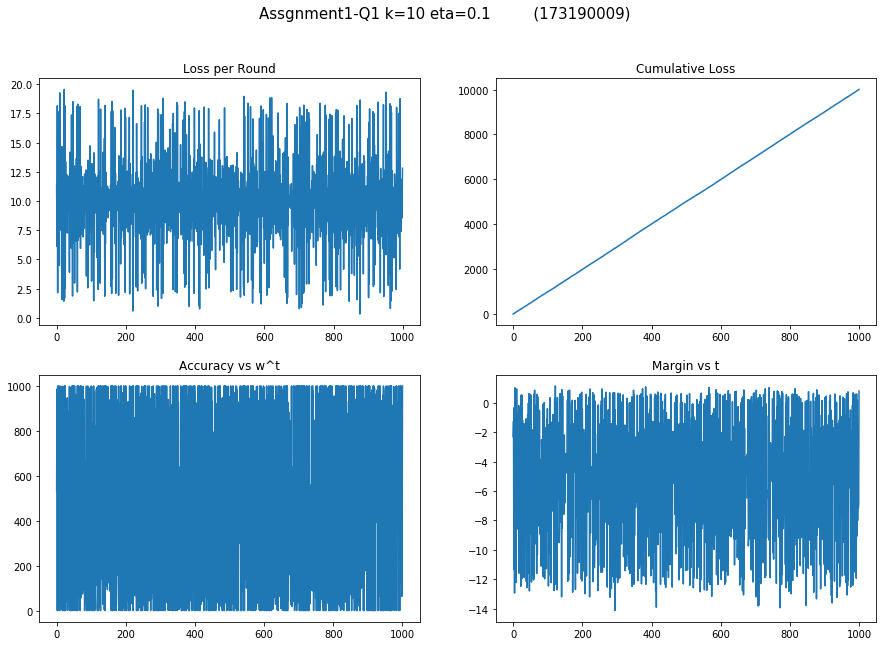

In [175]:
def loss_fn1(k, y_actual, W, x):    return max(0, k-y_actual*np.dot(W,x))
def grad_fn1(k, y_actual, W, x):    return y_actual*x #Called only if loss >0 in Model
model1=Q1Model(loss_fn1, grad_fn1, k=10, data=data, eta=0.1, projection=projection1)
model1.fit()
model1.plot()

### Projection Algorithm
for any given weight vector $w^t \in \mathbb{R}^{100}$, it's projection on the closed set $C =\{w \in \mathbb{R}^{100} : ||w||_1\leq1\}$

$$\Pi_c[w^t] = \underset{y}{argmin} \ ||w^t-y||_2 \quad y \in C $$

In [176]:
#Copied this cell from https://gist.github.com/daien/1272551/edd95a6154106f8e28209a1c7964623ef8397246
#with some minor tweaks
def euclidean_proj_simplex(v, s=1):
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
#     print(f"Shabe of Vector: {v.shape}")
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
#     print(type(cssv), type(u), type(s), type(n))
    rho = np.nonzero(u * np.arange(1, n[0]+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = float(cssv[rho] - s) / rho
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w


def projection2(v, s=1):
    v=v.flatten()
#     print(f"V Shape: {v.shape}")
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n = v.shape  # will raise ValueError if v is not 1-D
    # compute the vector of absolute values
    u = np.abs(v)
    # check if v is already a solution
    if u.sum() <= s:
        # L1-norm is <= s
        v.reshape((1,n[0]))
        return v
    # v is not already a solution: optimum lies on the boundary (norm == s)
    # project *u* on the simplex
    w = euclidean_proj_simplex(u, s=s)
    # compute the solution to the original problem on v
    w *= np.sign(v)
    w.reshape((1,n[0]))
    return w

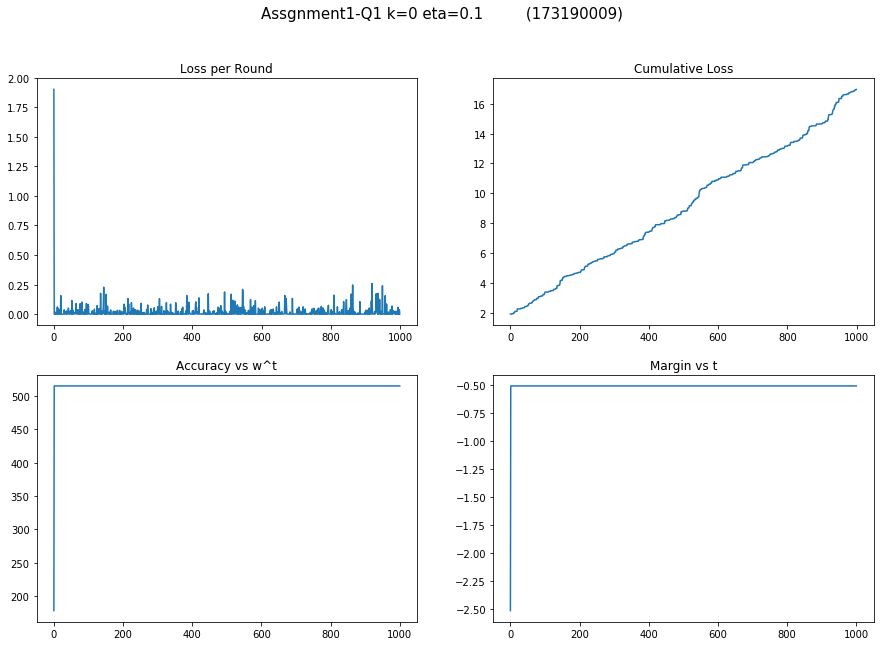

In [179]:
def loss_fn2(k, y_actual, W, x): return (max(0, k-y_actual*np.dot(W,x)))**2
def grad_fn2(k, y_actual, W, x): 
    loss=loss_fn2(k, y_actual, W, x)
    return 2*(k-y_actual*np.dot(W,x))*(y_actual*x) if loss>0 else 0

model=Q1Model(loss_fn2, grad_fn2, k=0, data=data, eta=0.1, projection=projection2, Q=2)
model.fit()
model.plot()

In [180]:
model.W

array([-0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.02718856,  0.        , -0.01128114, -0.        ,
        0.04522214,  0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.00912062,  0.        ,  0.        ,  0.        ,
        0.02066909,  0.03900526,  0.        , -0.        , -0.01006625,
        0.        , -0.        , -0.03096972,  0.        , -0.        ,
       -0.        ,  0.06195653,  0.        , -0.        ,  0.        ,
       -0.        ,  0.00228459,  0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.01132675, -0.05511349, -0.        ,
        0.        , -0.        ,  0.10881086,  0.        ,  0.        ,
       -0.        , -0.02463549, -0.10623885,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.03904645, -0.        ,  0.04503466, -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.  

In [139]:
len(data)

1000